In [1]:
import sys
sys.path.append("/n/home12/binxuwang/Github/Neuro-ActMax-GAN-comparison")
import torch
import numpy as np
import os
import glob
from os.path import join
from tqdm import tqdm, trange
from PIL import Image
import pickle as pkl
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, TensorDataset
from core.utils.dataset_utils import ImagePathDataset, normalizer, denormalizer, ImageDataset_filter
from core.utils.plot_utils import saveallforms
from core.utils.dataset_utils import ImageDataset_filter
from core.utils.dataset_utils import create_imagenet_valid_dataset
from torchvision.datasets import ImageFolder
from neuro_data_analysis.neural_data_lib import load_img_resp_pairs_multiwindow, load_neural_data # load_img_resp_pairs_multiwindow


/n/home12/binxuwang/.conda/envs/torch/lib/python3.10/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [ ]:
# load the neural data
BFEStats_merge, BFEStats = load_neural_data()
rsp_wdws = [range(50, 200), range(0, 50), range(50, 100), range(100, 150), range(150, 200)]


In [9]:
import platform

if platform.system() == "Windows":
    stim_rootdir = "S:"
    device = "cuda"
elif platform.system() == "Darwin":
    stim_rootdir = "/Users/binxuwang/Network_mapping"
    device = "mps"
elif platform.system() == "Linux":
    stim_rootdir = "/n/holylabs/LABS/kempner_fellows/Users/binxuwang/Datasets"
    stim_rootdir = "/n/holyscratch01/kempner_fellows/Users/binxuwang/Datasets"
    stim_rootdir = r"/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Datasets"
    device = "cuda"

GANimgroot = join(stim_rootdir, "GAN_sample_fid")
os.listdir(GANimgroot)

['BigGAN_std_008',
 'resnet50_linf8_gradevol',
 'BigGAN_trunc07',
 'resnet50_linf8_gradevol_avgpool',
 'resnet50_linf8_gradevol_layer4',
 'BigGAN_1000cls_std07_invert',
 'resnet50_linf8_gradevol_layer3',
 'DeePSim_4std',
 'pink_noise']

In [12]:
default_tfm = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    normalizer,
])

In [10]:
rootdir = r"/n/holylabs/LABS/kempner_fellows/Users/binxuwang/Datasets/imagenet-valid"
INdataset = create_imagenet_valid_dataset(imgpix=224,rootdir=rootdir)
# dataloaders = DataLoader(INdataset, batch_size=256, shuffle=False, num_workers=8)

In [13]:
imgroot = join(GANimgroot, "BigGAN_1000cls_std07_invert")
FCinvertdataset = ImageDataset_filter(imgroot, glob_pattern="FC_invert*", 
                            transform=default_tfm)
BGorigdataset = ImageDataset_filter(imgroot, glob_pattern="BG*", 
                            transform=default_tfm)
BGBlurdataset = ImageDataset_filter(imgroot, glob_pattern="BG*",
                            transform=transforms.Compose([
                               transforms.ToTensor(), 
                               transforms.GaussianBlur([15, 15], sigma=9),
                               transforms.Resize((224, 224)),
                               normalizer,]))
print(len(FCinvertdataset), len(BGorigdataset), len(BGBlurdataset))

imageset_str = "DeePSim_4std"
FCdataset = ImageDataset_filter(join(GANimgroot, "DeePSim_4std"), 
                    glob_pattern="sample*", transform=default_tfm)
print(imageset_str, len(FCdataset))
imageset_str = "BigGAN_trunc07"
BGdataset = ImageDataset_filter(join(GANimgroot, "BigGAN_trunc07"), 
                    glob_pattern="sample*", transform=default_tfm)
print(imageset_str, len(BGdataset))
imageset_str = "BigGAN_std_008"
BGRNDdataset = ImageDataset_filter(join(GANimgroot, "BigGAN_std_008"), 
                    glob_pattern="sample*", transform=default_tfm)
print(imageset_str, len(BGRNDdataset))

imageset_str = "resnet50_linf8_gradevol"
gradevoldataset_fc = ImageDataset_filter(join(GANimgroot, "resnet50_linf8_gradevol"), 
                    glob_pattern="class*", transform=default_tfm)
print(imageset_str, len(gradevoldataset_fc))
imageset_str = "resnet50_linf8_gradevol_avgpool"
gradevoldataset_avgpool = ImageDataset_filter(join(GANimgroot, "resnet50_linf8_gradevol_avgpool"), 
                    glob_pattern="class*", transform=default_tfm)
print(imageset_str, len(gradevoldataset_avgpool))
imageset_str = "resnet50_linf8_gradevol_layer4"
gradevoldataset_layer4 = ImageDataset_filter(join(GANimgroot, "resnet50_linf8_gradevol_layer4"), 
                    glob_pattern="class*", transform=default_tfm)
print(imageset_str, len(gradevoldataset_layer4))
imageset_str = "resnet50_linf8_gradevol_layer3"
gradevoldataset_layer3 = ImageDataset_filter(join(GANimgroot, "resnet50_linf8_gradevol_layer3"), 
                    glob_pattern="class*", transform=default_tfm)
print(imageset_str, len(gradevoldataset_layer3))

21000 21000 21000
DeePSim_4std 50000
BigGAN_trunc07 50000
BigGAN_std_008 50000
resnet50_linf8_gradevol 50000
resnet50_linf8_gradevol_avgpool 51200
resnet50_linf8_gradevol_layer4 2332
resnet50_linf8_gradevol_layer3 51200


In [25]:
from scipy import stats
import numpy as np
from scipy import ndimage
import torch

def power_spectrum_freq(grey_image, verbose=False):
    
    image = grey_image
    # image[:,:] *=0
    # image[::2,::2] +=1
    npix = image.shape[0]
    if verbose:
        print(image.min(), image.max())

    fourier_image = np.fft.fftn(image)
    fourier_amplitudes = np.abs(fourier_image)**2

    kfreq = np.fft.fftfreq(npix) * npix
    kfreq2D = np.meshgrid(kfreq, kfreq)
    knrm = np.sqrt(kfreq2D[0]**2 + kfreq2D[1]**2)

    knrm = knrm.flatten()
    fourier_amplitudes = fourier_amplitudes.flatten()

    kbins = np.arange(0.5, npix//2+1, 1.)
    kvals = 0.5 * (kbins[1:] + kbins[:-1])
    Abins, _, _ = stats.binned_statistic(knrm, fourier_amplitudes,
                                        statistic = "mean",
                                        bins = kbins)
    Abins *= np.pi * (kbins[1:]**2 - kbins[:-1]**2)


    return kvals, Abins

In [32]:
def compute_PSD_dataset(dataset, len_kvals = 112, max_number=1000):
    Abins_col = []#np.zeros((len_kvals, len(FCdataset))
    for di, img in tqdm(enumerate(dataset)):
        if type(img) is tuple:
            img = img[0]
        if di >= max_number:
            break
        if img.ndim == 3:
            img = img.mean(dim=0)
        kvals, Abins = power_spectrum_freq(img)
        assert len(kvals) == len_kvals
        Abins_col.append(Abins)
    Abins_col = np.array(Abins_col)
    return kvals, Abins_col

In [35]:
num_workers = 8
device = "cuda"
PSD_root = "/n/holylabs/LABS/kempner_fellows/Users/binxuwang/Projects/GAN_img_PSDs"
# embed_dir = join(embed_root, "dinov2_vitb14")
os.makedirs(PSD_root, exist_ok=True)

for dataset, dataset_str  in [
    (INdataset, "ImageNet_valid"),
    (FCdataset, "DeePSim_4std"),
    (BGdataset, "BigGAN_trunc07"),
    (BGRNDdataset, "BigGAN_std_008"),
    # (gradevoldataset_fc, "resnet50_linf8_gradevol_fc"),
    # (gradevoldataset_avgpool, "resnet50_linf8_gradevol_avgpool"),
    # (gradevoldataset_layer4, "resnet50_linf8_gradevol_layer4"),
    # (gradevoldataset_layer3, "resnet50_linf8_gradevol_layer3"),
    # (FCinvertdataset, "BigGAN_1000cls_FC_invert"),
    # (BGorigdataset, "BigGAN_1000cls_BG_orig"),
    # (BGBlurdataset, "BigGAN_1000cls_BG_blur"),
]:
    kvals, Abins_col = compute_PSD_dataset(dataset, len_kvals=112, max_number=5000)
    # embeddings = embed_dataset(dataset, embed_model, batch_size=100, size=224, 
    #                            device=device, num_workers=num_workers)
    torch.cuda.empty_cache()
    pkl.dump( (kvals, Abins_col), 
             open(join(PSD_root, f"{dataset_str}_PSDs.pkl"), "wb"))
    print(f"saved {dataset_str} to {PSD_root} : {Abins_col.shape}")

0it [00:00, ?it/s]

1000it [00:05, 183.18it/s]


saved DeePSim_4std to /n/holylabs/LABS/kempner_fellows/Users/binxuwang/Projects/GAN_img_PSDs : (1000, 112)


1000it [00:30, 32.43it/s]


saved BigGAN_trunc07 to /n/holylabs/LABS/kempner_fellows/Users/binxuwang/Projects/GAN_img_PSDs : (1000, 112)


1000it [00:27, 35.92it/s]

saved BigGAN_std_008 to /n/holylabs/LABS/kempner_fellows/Users/binxuwang/Projects/GAN_img_PSDs : (1000, 112)


In [73]:
PSD_col = {}
for dataset, dataset_str  in [
    (INdataset, "ImageNet_valid"),
    (FCdataset, "DeePSim_4std"),
    (BGdataset, "BigGAN_trunc07"),
    (BGRNDdataset, "BigGAN_std_008"),
    # (gradevoldataset_fc, "resnet50_linf8_gradevol_fc"),
    # (gradevoldataset_avgpool, "resnet50_linf8_gradevol_avgpool"),
    # (gradevoldataset_layer4, "resnet50_linf8_gradevol_layer4"),
    # (gradevoldataset_layer3, "resnet50_linf8_gradevol_layer3"),
    # (FCinvertdataset, "BigGAN_1000cls_FC_invert"),
    # (BGorigdataset, "BigGAN_1000cls_BG_orig"),
    # (BGBlurdataset, "BigGAN_1000cls_BG_blur"),
]:
    PSD_col[dataset_str] = pkl.load(open(join(PSD_root, f"{dataset_str}_PSDs_224.pkl"), "rb"))

### without resize

In [50]:
default_tfm_norsz = transforms.Compose([
    # transforms.Resize((224, 224)),
    transforms.ToTensor(),
    normalizer,
])

In [51]:
rootdir = r"/n/holylabs/LABS/kempner_fellows/Users/binxuwang/Datasets/imagenet-valid"
INdataset = create_imagenet_valid_dataset(imgpix=256,rootdir=rootdir)

In [52]:
imgroot = join(GANimgroot, "BigGAN_1000cls_std07_invert")
FCinvertdataset = ImageDataset_filter(imgroot, glob_pattern="FC_invert*", 
                            transform=default_tfm_norsz)
BGorigdataset = ImageDataset_filter(imgroot, glob_pattern="BG*", 
                            transform=default_tfm_norsz)
BGBlurdataset = ImageDataset_filter(imgroot, glob_pattern="BG*",
                            transform=transforms.Compose([
                               transforms.ToTensor(), 
                               transforms.GaussianBlur([15, 15], sigma=9),
                               transforms.Resize((256, 256)),
                               normalizer,]))
print(len(FCinvertdataset), len(BGorigdataset), len(BGBlurdataset))

imageset_str = "DeePSim_4std"
FCdataset = ImageDataset_filter(join(GANimgroot, "DeePSim_4std"), 
                    glob_pattern="sample*", transform=default_tfm_norsz)
print(imageset_str, len(FCdataset))
imageset_str = "BigGAN_trunc07"
BGdataset = ImageDataset_filter(join(GANimgroot, "BigGAN_trunc07"), 
                    glob_pattern="sample*", transform=default_tfm_norsz)
print(imageset_str, len(BGdataset))
imageset_str = "BigGAN_std_008"
BGRNDdataset = ImageDataset_filter(join(GANimgroot, "BigGAN_std_008"), 
                    glob_pattern="sample*", transform=default_tfm_norsz)
print(imageset_str, len(BGRNDdataset))

imageset_str = "resnet50_linf8_gradevol"
gradevoldataset_fc = ImageDataset_filter(join(GANimgroot, "resnet50_linf8_gradevol"), 
                    glob_pattern="class*", transform=default_tfm_norsz)
print(imageset_str, len(gradevoldataset_fc))
imageset_str = "resnet50_linf8_gradevol_avgpool"
gradevoldataset_avgpool = ImageDataset_filter(join(GANimgroot, "resnet50_linf8_gradevol_avgpool"), 
                    glob_pattern="class*", transform=default_tfm_norsz)
print(imageset_str, len(gradevoldataset_avgpool))
imageset_str = "resnet50_linf8_gradevol_layer4"
gradevoldataset_layer4 = ImageDataset_filter(join(GANimgroot, "resnet50_linf8_gradevol_layer4"), 
                    glob_pattern="class*", transform=default_tfm_norsz)
print(imageset_str, len(gradevoldataset_layer4))
imageset_str = "resnet50_linf8_gradevol_layer3"
gradevoldataset_layer3 = ImageDataset_filter(join(GANimgroot, "resnet50_linf8_gradevol_layer3"), 
                    glob_pattern="class*", transform=default_tfm_norsz)
print(imageset_str, len(gradevoldataset_layer3))

21000 21000 21000
DeePSim_4std 50000
BigGAN_trunc07 50000
BigGAN_std_008 50000
resnet50_linf8_gradevol 50000
resnet50_linf8_gradevol_avgpool 51200
resnet50_linf8_gradevol_layer4 2332
resnet50_linf8_gradevol_layer3 51200


In [54]:
num_workers = 8
device = "cuda"
PSD_root = "/n/holylabs/LABS/kempner_fellows/Users/binxuwang/Projects/GAN_img_PSDs"
# embed_dir = join(embed_root, "dinov2_vitb14")
os.makedirs(PSD_root, exist_ok=True)

for dataset, dataset_str  in [
    (INdataset, "ImageNet_valid"),
    (FCdataset, "DeePSim_4std"),
    (BGdataset, "BigGAN_trunc07"),
    (BGRNDdataset, "BigGAN_std_008"),
    # (gradevoldataset_fc, "resnet50_linf8_gradevol_fc"),
    # (gradevoldataset_avgpool, "resnet50_linf8_gradevol_avgpool"),
    # (gradevoldataset_layer4, "resnet50_linf8_gradevol_layer4"),
    # (gradevoldataset_layer3, "resnet50_linf8_gradevol_layer3"),
    # (FCinvertdataset, "BigGAN_1000cls_FC_invert"),
    # (BGorigdataset, "BigGAN_1000cls_BG_orig"),
    # (BGBlurdataset, "BigGAN_1000cls_BG_blur"),
]:
    kvals, Abins_col = compute_PSD_dataset(dataset, len_kvals=128, max_number=5000)
    # embeddings = embed_dataset(dataset, embed_model, batch_size=100, size=224, 
    #                            device=device, num_workers=num_workers)
    torch.cuda.empty_cache()
    pkl.dump( (kvals, Abins_col), 
             open(join(PSD_root, f"{dataset_str}_PSDs_256.pkl"), "wb"))
    print(f"saved {dataset_str} to {PSD_root} : {Abins_col.shape}")

0it [00:00, ?it/s]

5000it [02:39, 31.33it/s]


saved ImageNet_valid to /n/holylabs/LABS/kempner_fellows/Users/binxuwang/Projects/GAN_img_PSDs : (5000, 128)


5000it [00:27, 183.83it/s]


saved DeePSim_4std to /n/holylabs/LABS/kempner_fellows/Users/binxuwang/Projects/GAN_img_PSDs : (5000, 128)


5000it [01:30, 55.35it/s] 


saved BigGAN_trunc07 to /n/holylabs/LABS/kempner_fellows/Users/binxuwang/Projects/GAN_img_PSDs : (5000, 128)


5000it [01:23, 60.24it/s]

saved BigGAN_std_008 to /n/holylabs/LABS/kempner_fellows/Users/binxuwang/Projects/GAN_img_PSDs : (5000, 128)


In [55]:
PSD256_col = {}
for dataset, dataset_str  in [
    (INdataset, "ImageNet_valid"),
    (FCdataset, "DeePSim_4std"),
    (BGdataset, "BigGAN_trunc07"),
    (BGRNDdataset, "BigGAN_std_008"),
    # (gradevoldataset_fc, "resnet50_linf8_gradevol_fc"),
    # (gradevoldataset_avgpool, "resnet50_linf8_gradevol_avgpool"),
    # (gradevoldataset_layer4, "resnet50_linf8_gradevol_layer4"),
    # (gradevoldataset_layer3, "resnet50_linf8_gradevol_layer3"),
    # (FCinvertdataset, "BigGAN_1000cls_FC_invert"),
    # (BGorigdataset, "BigGAN_1000cls_BG_orig"),
    # (BGBlurdataset, "BigGAN_1000cls_BG_blur"),
]:
    PSD256_col[dataset_str] = pkl.load(open(join(PSD_root, f"{dataset_str}_PSDs_256.pkl"), "rb"))

In [78]:
mean_var_col = {}
for dataset, dataset_str  in [
    (INdataset, "ImageNet_valid"),
    (FCdataset, "DeePSim_4std"),
    (BGdataset, "BigGAN_trunc07"),
    (BGRNDdataset, "BigGAN_std_008"),
    # (gradevoldataset_fc, "resnet50_linf8_gradevol_fc"),
    # (gradevoldataset_avgpool, "resnet50_linf8_gradevol_avgpool"),
    # (gradevoldataset_layer4, "resnet50_linf8_gradevol_layer4"),
    # (gradevoldataset_layer3, "resnet50_linf8_gradevol_layer3"),
    # (FCinvertdataset, "BigGAN_1000cls_FC_invert"),
    # (BGorigdataset, "BigGAN_1000cls_BG_orig"),
    # (BGBlurdataset, "BigGAN_1000cls_BG_blur"),
]:
    mean_var_list = []
    xtsr = []
    for ii, img in enumerate(dataset):
        if ii >= 5000:
            break
        if type(img) is tuple:
            img = img[0]
        xtsr.append(img)
    xtsr = torch.stack(xtsr)
    xtsr_gs = xtsr.mean(dim=1)
    mean_vec = xtsr_gs.mean(dim=[1,2])
    var_vec = xtsr_gs.var(dim=[1,2])
    mean_var_col[dataset_str] = (mean_vec, var_vec)
    print(f"saved {dataset_str} to {PSD_root} : {mean_vec.shape}, mean: {mean_vec.mean()}, var: {var_vec.mean()}")

saved ImageNet_valid to /n/holylabs/LABS/kempner_fellows/Users/binxuwang/Projects/GAN_img_PSDs : torch.Size([5000]), mean: -0.01591626927256584, var: 0.9798197150230408
saved DeePSim_4std to /n/holylabs/LABS/kempner_fellows/Users/binxuwang/Projects/GAN_img_PSDs : torch.Size([5000]), mean: 0.28738081455230713, var: 1.9403904676437378
saved BigGAN_trunc07 to /n/holylabs/LABS/kempner_fellows/Users/binxuwang/Projects/GAN_img_PSDs : torch.Size([5000]), mean: -0.05281072482466698, var: 0.9118361473083496
saved BigGAN_std_008 to /n/holylabs/LABS/kempner_fellows/Users/binxuwang/Projects/GAN_img_PSDs : torch.Size([5000]), mean: -0.12859880924224854, var: 0.7434418797492981


In [89]:
pkl.dump(mean_var_col, open(join(PSD_root, "sample_mean_var_256.pkl"), "wb"))

In [83]:
var_col = {dataset_str: var_vec[:, None] for dataset_str, (mean_vec, var_vec) in mean_var_col.items()}

### Results visualize

In [79]:
def visualize_PSDs(PSD_col, normalize=False, error="sem", expfit=False, ax=None, normalizers=None):
    if ax is None:
        figh = plt.figure()
    else:
        figh = ax.figure
        plt.sca(ax)
    for di, dataset_str in enumerate(PSD_col.keys()):
        kvals, Abins_col = PSD_col[dataset_str]
        if normalize:
            if normalizers is None:
                Abins_norm = Abins_col/Abins_col.sum(axis=1, keepdims=True)
            else:
                scaler = normalizers[dataset_str]
                Abins_norm = Abins_col / scaler
        else:
            Abins_norm = Abins_col
        mean_Abins = Abins_norm.mean(0)
        plt.plot(kvals, mean_Abins, label=dataset_str, alpha=0.5, lw=2, color=f"C{di}")
        
        if expfit:
            log_kvals = np.log10(kvals)
            log_mean_Abins = np.log10(mean_Abins)
            # Perform linear regression on the log data
            slope, intercept = np.polyfit(log_kvals, log_mean_Abins, 1)
            # Plot the fitted line on a log-log scale
            plt.plot(kvals, 10**(intercept + slope * log_kvals), label=f'fit: slope={slope:.2f}, b={intercept:.2f}', 
                     alpha=0.5, lw=2, linestyle="--",color=f"C{di}")
            
        if error == "sem":
            sem = Abins_norm.std(0)/np.sqrt(Abins_norm.shape[0])
            lower, upper = mean_Abins-sem, mean_Abins+sem
        elif error == "std":
            std = Abins_norm.std(0)
            lower, upper = mean_Abins-std, mean_Abins+std
        elif error == "ci":
            # percentile
            lower, upper = np.percentile(Abins_norm, [5, 95], axis=0)
        plt.fill_between(kvals, lower, upper, alpha=0.3, color=f"C{di}")
    plt.xscale("log")
    plt.yscale("log")
    # plt.title(dataset_str)
    plt.legend()
    plt.title("Normalized PSDs, sum to 1")
    return figh

Text(0.5, 1.0, 'Normalized PSDs 256 pix res')

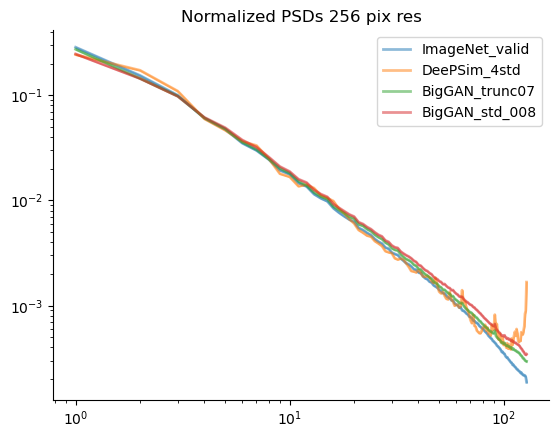

In [90]:
figh = visualize_PSDs(PSD256_col, normalize=True, error="sem", expfit=False)
figh.gca().set_title("Normalized PSDs 256 pix res")

Text(0.5, 1.0, 'Variance Normalized PSDs 256 pix res')

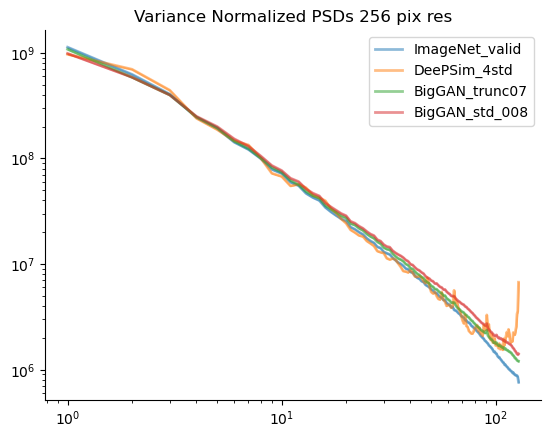

In [91]:
figh = visualize_PSDs(PSD256_col, normalize=True, error="sem", expfit=False, normalizers=var_col)
figh.gca().set_title("Variance Normalized PSDs 256 pix res")

Text(0.5, 1.0, 'Normalized PSDs 256 pix res, exponent fit')

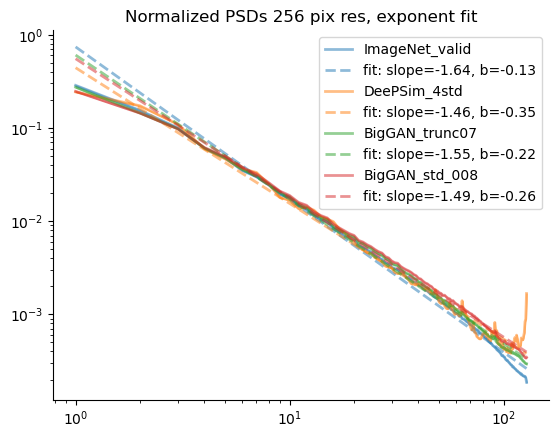

In [92]:
figh = visualize_PSDs(PSD256_col, normalize=True, error="sem", expfit=True)
figh.gca().set_title("Normalized PSDs 256 pix res, exponent fit")

Text(0.5, 1.0, 'Raw PSDs 256 pix res')

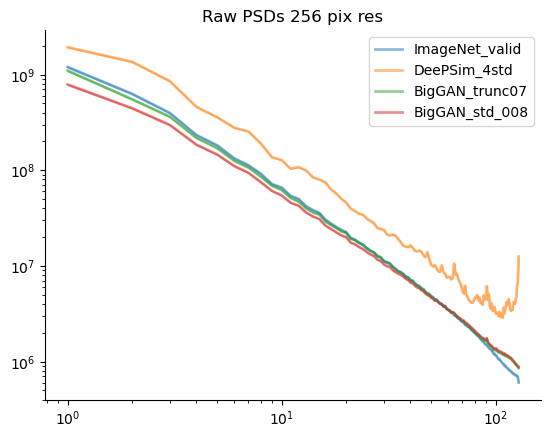

In [93]:
figh = visualize_PSDs(PSD256_col, normalize=False, error="sem", expfit=False)
figh.gca().set_title("Raw PSDs 256 pix res")

Text(0.5, 1.0, 'Variance Normalized PSDs 224 pix res')

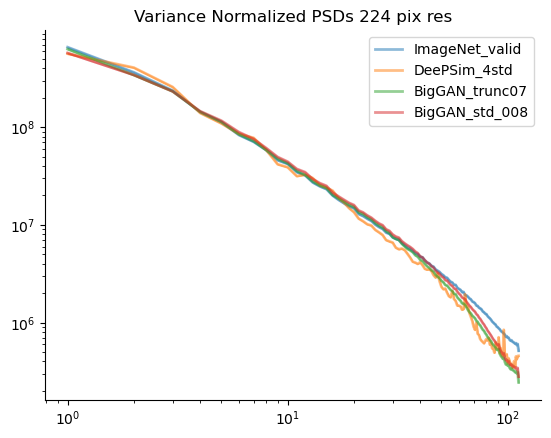

In [94]:
figh = visualize_PSDs(PSD_col, normalize=True, error="sem", expfit=False, normalizers=var_col)
figh.gca().set_title("Variance Normalized PSDs 224 pix res")

Text(0.5, 1.0, 'Normalized PSDs 224 pix res')

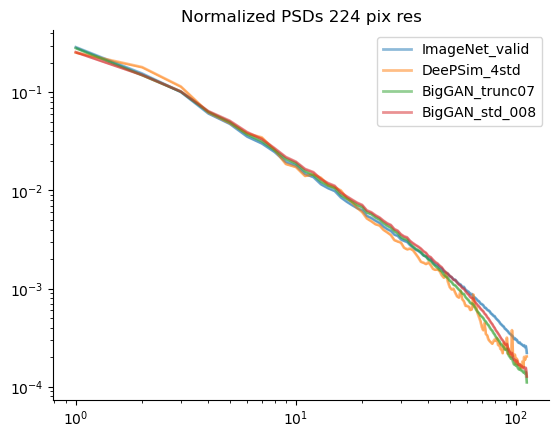

In [95]:
figh = visualize_PSDs(PSD_col, normalize=True, error="sem", expfit=False)
figh.gca().set_title("Normalized PSDs 224 pix res")

Text(0.5, 1.0, 'Normalized PSDs 224 pix res, exponent fit')

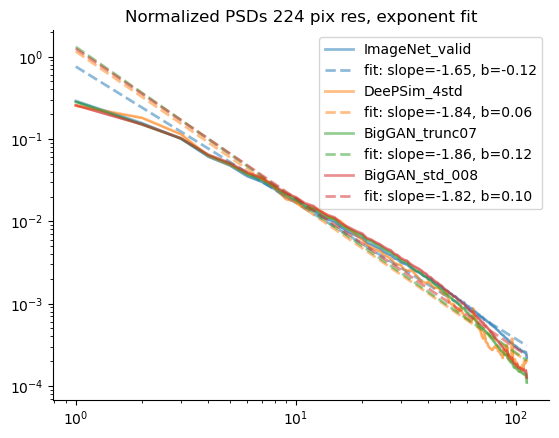

In [96]:
figh = visualize_PSDs(PSD_col, normalize=True, error="sem", expfit=True)
figh.gca().set_title("Normalized PSDs 224 pix res, exponent fit")

Text(0.5, 1.0, 'Raw PSDs 224 pix res')

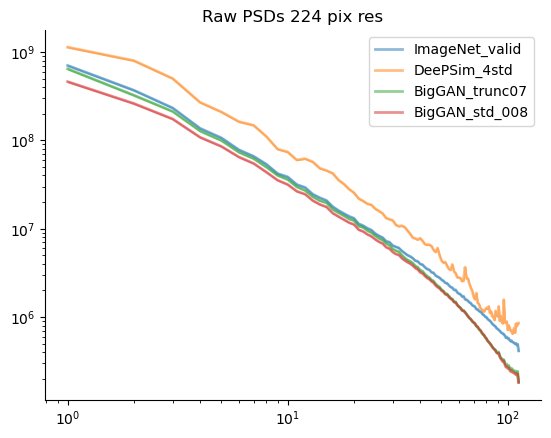

In [97]:
figh = visualize_PSDs(PSD_col, normalize=False, error="sem", expfit=False)
figh.gca().set_title("Raw PSDs 224 pix res")

### Scratch zone

Text(0.5, 1.0, 'Raw PSDs')

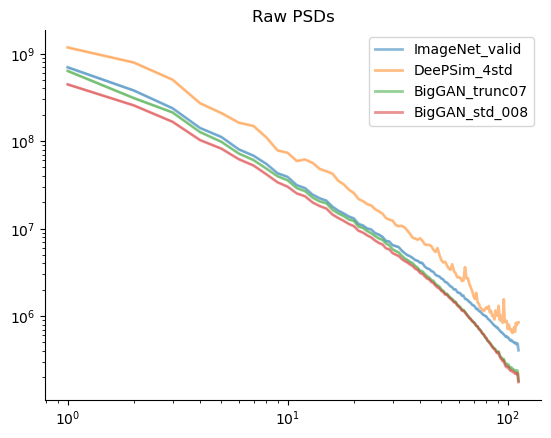

In [47]:
plt.figure()
for dataset_str in PSD_col.keys():
    kvals, Abins_col = PSD_col[dataset_str]
    plt.plot(kvals, Abins_col.mean(0), label=dataset_str, alpha=0.5, lw=2)
    # percentile
    Abin05, Abin95 = np.percentile(Abins_col, [5, 95], axis=0)
    sem = Abins_col.std(0)/np.sqrt(Abins_col.shape[0])
    # plt.fill_between(kvals, Abin05, Abin95, alpha=0.3, )
    plt.fill_between(kvals, Abins_col.mean(0)-sem, Abins_col.mean(0)+sem, alpha=0.3, )
    plt.xscale("log")
    plt.yscale("log")
    # plt.title(dataset_str)
plt.legend()
plt.title("Raw PSDs")

Text(0.5, 1.0, 'Normalized PSDs, sum to 1')

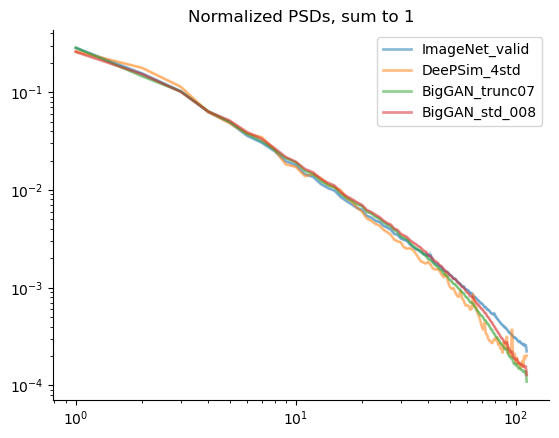

In [48]:
plt.figure()
for dataset_str in PSD_col.keys():
    kvals, Abins_col = PSD_col[dataset_str]
    Abins_norm = Abins_col/Abins_col.sum(axis=1, keepdims=True)
    plt.plot(kvals, Abins_norm.mean(0), label=dataset_str, alpha=0.5, lw=2)
    # percentile
    Abin05, Abin95 = np.percentile(Abins_norm, [5, 95], axis=0)
    sem = Abins_norm.std(0)/np.sqrt(Abins_norm.shape[0])
    # plt.fill_between(kvals, Abin05, Abin95, alpha=0.3, )
    plt.fill_between(kvals, Abins_norm.mean(0)-sem, Abins_norm.mean(0)+sem, alpha=0.3, )
    plt.xscale("log")
    plt.yscale("log")
    # plt.title(dataset_str)
plt.legend()
plt.title("Normalized PSDs, sum to 1")

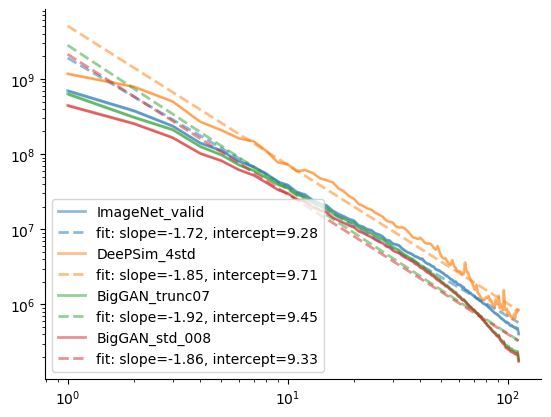

In [46]:


plt.figure()
for i, dataset_str in enumerate(PSD_col.keys()):
    kvals, Abins_col = PSD_col[dataset_str]
    Abins_norm = Abins_col/Abins_col.sum(axis=1, keepdims=True)
    mean_Abins = Abins_col.mean(0)
    # percentile
    Abin05, Abin95 = np.percentile(Abins_col, [5, 95], axis=0)
    sem = Abins_col.std(0)/np.sqrt(Abins_col.shape[0])
    # Take the log of the data
    log_kvals = np.log10(kvals)
    log_mean_Abins = np.log10(mean_Abins)
    # Perform linear regression on the log data
    slope, intercept = np.polyfit(log_kvals, log_mean_Abins, 1)
    # Plot the original data on a log-log scale
    plt.plot(kvals, mean_Abins, label=dataset_str, alpha=0.5, lw=2, color=f"C{i}")
    # Plot the fitted line on a log-log scale
    plt.plot(kvals, 10**(intercept + slope * log_kvals), label=f'fit: slope={slope:.2f}, intercept={intercept:.2f}', alpha=0.5, lw=2, linestyle="--",color=f"C{i}")
    plt.fill_between(kvals, mean_Abins-sem, mean_Abins+sem, alpha=0.3, color=f"C{i}")
    plt.xscale("log")
    plt.yscale("log")
plt.legend()

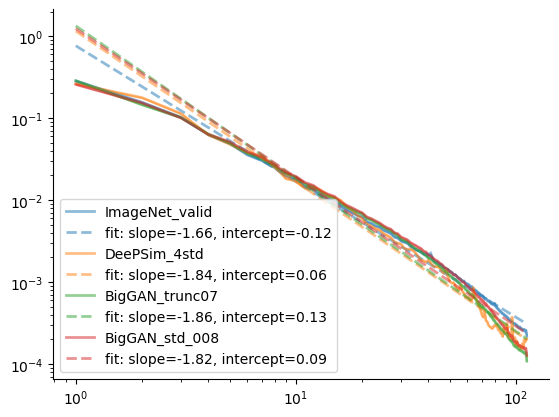

In [45]:
import numpy as np
import matplotlib.pyplot as plt

plt.figure()
for i, dataset_str in enumerate(PSD_col.keys()):
    kvals, Abins_col = PSD_col[dataset_str]
    Abins_norm = Abins_col/Abins_col.sum(axis=1, keepdims=True)
    mean_Abins = Abins_norm.mean(0)
    # percentile
    Abin05, Abin95 = np.percentile(Abins_norm, [5, 95], axis=0)
    sem = Abins_norm.std(0)/np.sqrt(Abins_norm.shape[0])
    # Take the log of the data
    log_kvals = np.log10(kvals)
    log_mean_Abins = np.log10(mean_Abins)
    # Perform linear regression on the log data
    slope, intercept = np.polyfit(log_kvals, log_mean_Abins, 1)
    # Plot the original data on a log-log scale
    plt.plot(kvals, mean_Abins, label=dataset_str, alpha=0.5, lw=2, color=f"C{i}")
    # Plot the fitted line on a log-log scale
    plt.plot(kvals, 10**(intercept + slope * log_kvals), label=f'fit: slope={slope:.2f}, intercept={intercept:.2f}', alpha=0.5, lw=2, linestyle="--",color=f"C{i}")
    plt.fill_between(kvals, mean_Abins-sem, mean_Abins+sem, alpha=0.3, color=f"C{i}")
    plt.xscale("log")
    plt.yscale("log")
plt.legend()

In [ ]:
plt.figure()
for dataset_str in PSD_col.keys():
    kvals, Abins_col = PSD_col[dataset_str]
    Abins_norm = Abins_col/Abins_col.sum(axis=1, keepdims=True)
    plt.plot(kvals, Abins_norm.mean(0), label=dataset_str, alpha=0.5, lw=2)
    # percentile
    Abin05, Abin95 = np.percentile(Abins_norm, [5, 95], axis=0)
    sem = Abins_norm.std(0)/np.sqrt(Abins_norm.shape[0])
    # plt.fill_between(kvals, Abin05, Abin95, alpha=0.3, )
    plt.fill_between(kvals, Abins_norm.mean(0)-sem, Abins_norm.mean(0)+sem, alpha=0.3, )
    plt.xscale("log")
    plt.yscale("log")
    # plt.title(dataset_str)
plt.legend()